In [435]:
import os
import re
from pathlib import Path
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [442]:
csv_file = tf.keras.utils.get_file(
    origin='https://itsci.mju.ac.th/downloads/watcharin/datasets/pv/device-1.csv.tar.gz')
csv_file

2132644/2132644 ━━━━━━━━━━━━━━━━━━━━ 2s 1us/step


'/Users/watcharinsarachai/.keras/datasets/device-1.csv.tar.gz'

In [317]:
df = pd.read_csv(csv_file)
row_count = df.shape[0]
print(f"Total rows: {row_count}")
df.head(5)

Total rows: 138238


,datetime,ambient_temperature,current_power,current_value_of_consumption,external_energy_supply,grid_feed_in,internal_power_supply,self_consumption,temperature_measurement,total_irradiation
0,2021-11-06 11:15:00,30.288889,46519.355556,37280.422222,NaN,9238.933333,37280.422222,37280.422222,58.022222,798.444444
1,2021-11-06 11:30:00,30.076923,47600.714286,39472.626374,NaN,9397.756098,39132.406593,39132.406593,58.263736,812.571429
2,2021-11-06 11:45:00,30.629213,47056.988764,32669.393258,NaN,14387.595506,32669.393258,32669.393258,57.235955,807.224719
3,2021-11-06 12:00:00,31.021978,48415.835165,36126.516484,NaN,12289.318681,36126.516484,36126.516484,56.846154,817.527473
4,2021-11-06 12:15:00,31.831461,49345.404494,36879.966292,NaN,12465.438202,36879.966292,36879.966292,55.842697,816.651685


In [318]:
# Check what years exist in your dataset
date_col = 'datetime'  # Replace with your actual column name

# Ensure timestamp column is datetime type
if df[date_col].dtype != 'datetime64[ns]':
    df[date_col] = pd.to_datetime(df[date_col])

In [319]:
print(df[date_col].dt.year.unique())
print(df[date_col].dt.year.value_counts())

[2021 2022 2023 2024 2025]
datetime
2024    35136
2022    35040
2023    35040
2025    27691
2021     5331
Name: count, dtype: int64


In [320]:
print(df.shape)
print(df[date_col].min())
print(df[date_col].max())

(138238, 10)
2021-11-06 11:15:00
2025-10-16 10:30:00


In [321]:
# Sort by time if it exists
df.index = df[date_col]
df.pop(date_col)
df = df.sort_index()
print(df.shape)
df.head(5)

(138238, 9)


,ambient_temperature,current_power,current_value_of_consumption,external_energy_supply,grid_feed_in,internal_power_supply,self_consumption,temperature_measurement,total_irradiation
datetime,,,,,,,,,
2021-11-06 11:15:00,30.288889,46519.355556,37280.422222,NaN,9238.933333,37280.422222,37280.422222,58.022222,798.444444
2021-11-06 11:30:00,30.076923,47600.714286,39472.626374,NaN,9397.756098,39132.406593,39132.406593,58.263736,812.571429
2021-11-06 11:45:00,30.629213,47056.988764,32669.393258,NaN,14387.595506,32669.393258,32669.393258,57.235955,807.224719
2021-11-06 12:00:00,31.021978,48415.835165,36126.516484,NaN,12289.318681,36126.516484,36126.516484,56.846154,817.527473
2021-11-06 12:15:00,31.831461,49345.404494,36879.966292,NaN,12465.438202,36879.966292,36879.966292,55.842697,816.651685


In [322]:
# Try inference first
interval_time = pd.infer_freq(df.index)
print(interval_time)

if interval_time is None:
    delta = df.index.to_series().diff().dropna()
    d = delta.mode().iloc[0] if not delta.mode().empty else delta.median()
    if d % pd.Timedelta(days=1) == pd.Timedelta(0):
        interval_time = 'D'
    elif d % pd.Timedelta(hours=1) == pd.Timedelta(0):
        interval_time = f"{int(d / pd.Timedelta(hours=1))}h"
    elif d % pd.Timedelta(minutes=1) == pd.Timedelta(0):
        interval_time = f"{int(d / pd.Timedelta(minutes=1))}min"
    else:
        interval_time = f"{int(d.total_seconds())}s"
print(interval_time)

start_date = df.index.min().floor(interval_time)
end_date = df.index.max().floor(interval_time)
complete_index = pd.date_range(start=start_date, end=end_date, freq=interval_time)
print(complete_index.shape)
print(complete_index.min())
print(complete_index.max())

15min
15min
(138238,)
2021-11-06 11:15:00
2025-10-16 10:30:00


In [323]:
# Create a DataFrame with the complete index
df_complete = pd.DataFrame(index=complete_index)
# Join with original data
df_with_all_times = df_complete.join(df)

print(df.shape)
print(df_with_all_times.shape)

df_with_all_times.head(5)

(138238, 9)
(138238, 9)


,ambient_temperature,current_power,current_value_of_consumption,external_energy_supply,grid_feed_in,internal_power_supply,self_consumption,temperature_measurement,total_irradiation
2021-11-06 11:15:00,30.288889,46519.355556,37280.422222,NaN,9238.933333,37280.422222,37280.422222,58.022222,798.444444
2021-11-06 11:30:00,30.076923,47600.714286,39472.626374,NaN,9397.756098,39132.406593,39132.406593,58.263736,812.571429
2021-11-06 11:45:00,30.629213,47056.988764,32669.393258,NaN,14387.595506,32669.393258,32669.393258,57.235955,807.224719
2021-11-06 12:00:00,31.021978,48415.835165,36126.516484,NaN,12289.318681,36126.516484,36126.516484,56.846154,817.527473
2021-11-06 12:15:00,31.831461,49345.404494,36879.966292,NaN,12465.438202,36879.966292,36879.966292,55.842697,816.651685


In [324]:
# Print missing data statistics
# Count rows that are entirely NaN
missing_count = df_with_all_times.isna().all(axis=1).sum()
print(f"Found {missing_count} rows with all NA values, out of {len(complete_index)} expected")

# Count columns where all values are NaN
all_na_cols = df_with_all_times.columns[df_with_all_times.isna().all(axis=0)].tolist()
count = len(all_na_cols)
print(f"Found {count} columns with all NA: {all_na_cols}")

Found 58121 rows with all NA values, out of 138238 expected
Found 0 columns with all NA: []


In [325]:
all_zero_count = (df_with_all_times == 0).all(axis=1).sum()
# Or get column names:
all_zero_cols = df.columns[(df_with_all_times == 0).all()].tolist()
print(f"Found {all_zero_count} zero value, out of {len(complete_index)} expected")
print(f"Found {all_zero_cols}")

Found 0 zero value, out of 138238 expected
Found []


In [326]:
all_cols = [c for c in df_with_all_times.columns]
print(all_cols)

['ambient_temperature', 'current_power', 'current_value_of_consumption', 'external_energy_supply', 'grid_feed_in', 'internal_power_supply', 'self_consumption', 'temperature_measurement', 'total_irradiation']


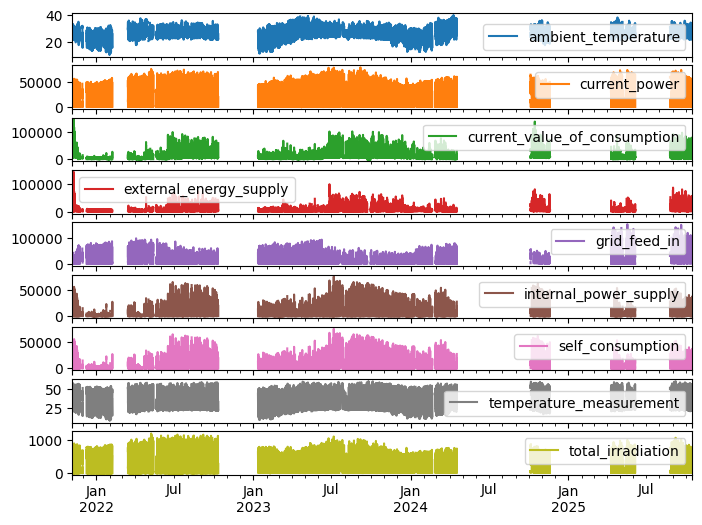

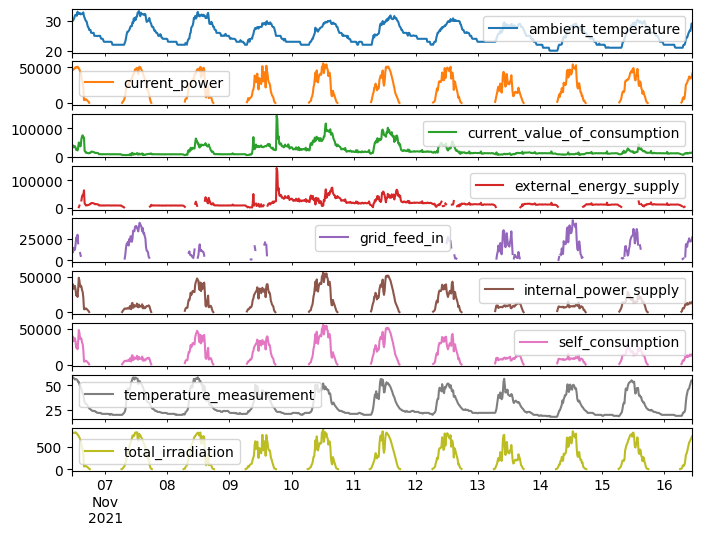

In [327]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

plot_features = df_with_all_times[all_cols]
plot_features.index = complete_index
_ = plot_features.plot(subplots=True)

plot_features = df_with_all_times[all_cols][:960]
plot_features.index = complete_index[:960]
_ = plot_features.plot(subplots=True)

In [328]:
# Replace all NaN values in the DataFrame with 0
df_filled = df_with_all_times.fillna(0)
df_filled.shape

(138238, 9)

In [329]:
# Count NaNs in each column
print(df_filled.isna().sum())

ambient_temperature             0
current_power                   0
current_value_of_consumption    0
external_energy_supply          0
grid_feed_in                    0
internal_power_supply           0
self_consumption                0
temperature_measurement         0
total_irradiation               0
dtype: int64


In [330]:
df_filled.min()

ambient_temperature             0.0
current_power                   0.0
current_value_of_consumption    0.0
external_energy_supply          0.0
grid_feed_in                    0.0
internal_power_supply           0.0
self_consumption                0.0
temperature_measurement         0.0
total_irradiation               0.0
dtype: float64

In [331]:
df_filled.max()

ambient_temperature                 40.010989
current_power                    78259.890110
current_value_of_consumption    145244.764045
external_energy_supply          145244.764045
grid_feed_in                    151143.101124
internal_power_supply            74895.123596
self_consumption                 74895.123596
temperature_measurement             61.373626
total_irradiation                 1183.054945
dtype: float64

# Start to fix missing row

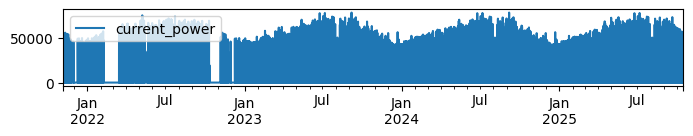

In [404]:
mpl.rcParams['figure.figsize'] = (8, 1)

plot_cols = ['current_power']
plot_features = df_filled[plot_cols]
plot_features.index = df_filled.index
_ = plot_features.plot(subplots=True)

In [416]:
## Create a copy of the dataframe
df_fixed = df_filled.copy()

# Variables from your code
year_to_fix = 2021
year_from = 2022

In [417]:
# Create date pattern columns BEFORE any filtering
df_fixed['date_pattern'] = df_fixed.index.strftime('%m-%d %H:%M')
df_fixed['date_pattern'].head(5)

2021-11-06 11:15:00    11-06 11:15
2021-11-06 11:30:00    11-06 11:30
2021-11-06 11:45:00    11-06 11:45
2021-11-06 12:00:00    11-06 12:00
2021-11-06 12:15:00    11-06 12:15
Freq: 15min, Name: date_pattern, dtype: object

In [418]:
# Find year rows with zeros (using your existing mask)
mask_from_year = df_fixed.index.year == year_from
year_rows = df_fixed.loc[mask_from_year]
print(F"There are {year_rows.shape[0]} in {year_from}")
year_rows.head(5)

There are 35040 in 2022


,ambient_temperature,current_power,current_value_of_consumption,external_energy_supply,grid_feed_in,internal_power_supply,self_consumption,temperature_measurement,total_irradiation,date_pattern
2022-01-01 00:00:00,19.736264,0.0,7218.989011,7218.989011,0.0,0.0,0.0,17.000000,0.0,01-01 00:00
2022-01-01 00:15:00,20.000000,0.0,7262.022472,7262.022472,0.0,0.0,0.0,17.000000,0.0,01-01 00:15
2022-01-01 00:30:00,20.000000,0.0,7183.120879,7183.120879,0.0,0.0,0.0,16.978022,0.0,01-01 00:30
2022-01-01 00:45:00,19.651685,0.0,7198.382022,7198.382022,0.0,0.0,0.0,16.000000,0.0,01-01 00:45
2022-01-01 01:00:00,19.000000,0.0,7304.175824,7304.175824,0.0,0.0,0.0,16.000000,0.0,01-01 01:00


In [419]:
# Find year rows with zeros (using your existing mask)
mask_to_year = df_fixed.index.year == year_to_fix
year_rows = df_fixed.loc[mask_to_year]
print(F"There are {year_rows.shape[0]} in {year_to_fix}")
year_rows.head(5)

There are 5331 in 2021


,ambient_temperature,current_power,current_value_of_consumption,external_energy_supply,grid_feed_in,internal_power_supply,self_consumption,temperature_measurement,total_irradiation,date_pattern
2021-11-06 11:15:00,30.288889,46519.355556,37280.422222,0.0,9238.933333,37280.422222,37280.422222,58.022222,798.444444,11-06 11:15
2021-11-06 11:30:00,30.076923,47600.714286,39472.626374,0.0,9397.756098,39132.406593,39132.406593,58.263736,812.571429,11-06 11:30
2021-11-06 11:45:00,30.629213,47056.988764,32669.393258,0.0,14387.595506,32669.393258,32669.393258,57.235955,807.224719,11-06 11:45
2021-11-06 12:00:00,31.021978,48415.835165,36126.516484,0.0,12289.318681,36126.516484,36126.516484,56.846154,817.527473,11-06 12:00
2021-11-06 12:15:00,31.831461,49345.404494,36879.966292,0.0,12465.438202,36879.966292,36879.966292,55.842697,816.651685,11-06 12:15


In [420]:
zero_mask = df_fixed[all_cols].eq(0).all(axis=1)
zero_rows = df_fixed.loc[zero_mask]
print(F"All zero row: {zero_rows.shape[0]}")

mask_zeros = mask_to_year & zero_mask
rows_to_fix = df_fixed[mask_zeros].copy()
print(F"There are [{rows_to_fix.shape[0]}] zero's rows of year {year_to_fix} to be fixed.")
rows_to_fix.head(5)

All zero row: 2599
There are [1373] zero's rows of year 2021 to be fixed.


,ambient_temperature,current_power,current_value_of_consumption,external_energy_supply,grid_feed_in,internal_power_supply,self_consumption,temperature_measurement,total_irradiation,date_pattern
2021-11-20 06:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11-20 06:15
2021-11-20 06:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11-20 06:30
2021-11-20 06:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11-20 06:45
2021-11-20 07:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11-20 07:00
2021-11-20 07:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11-20 07:15


In [421]:
# Create lookup DataFrame from source year
source_data = df_fixed[mask_from_year]
lookup_df = source_data.drop_duplicates('date_pattern').set_index('date_pattern')[all_cols]
print(F"There are {lookup_df.shape[0]} rows from year {year_from}.")
lookup_df.head(5)

There are 35040 rows from year 2022.


,ambient_temperature,current_power,current_value_of_consumption,external_energy_supply,grid_feed_in,internal_power_supply,self_consumption,temperature_measurement,total_irradiation
date_pattern,,,,,,,,,
01-01 00:00,19.736264,0.0,7218.989011,7218.989011,0.0,0.0,0.0,17.000000,0.0
01-01 00:15,20.000000,0.0,7262.022472,7262.022472,0.0,0.0,0.0,17.000000,0.0
01-01 00:30,20.000000,0.0,7183.120879,7183.120879,0.0,0.0,0.0,16.978022,0.0
01-01 00:45,19.651685,0.0,7198.382022,7198.382022,0.0,0.0,0.0,16.000000,0.0
01-01 01:00,19.000000,0.0,7304.175824,7304.175824,0.0,0.0,0.0,16.000000,0.0


In [422]:
# Find which patterns harows_to_fixve matches and update them
matching_patterns = rows_to_fix['date_pattern'].isin(lookup_df.index)
matching_indices = rows_to_fix.loc[matching_patterns].index
print(f"Found {len(matching_indices)} rows with matching patterns in {year_from}")

Found 1373 rows with matching patterns in 2022


In [423]:
# Update values for all matching rows at once
if len(matching_indices) > 0:
    for col in all_cols:
        # Get the replacement values from the lookup table
        replacement_values = rows_to_fix.loc[matching_indices, 'date_pattern'].map(lookup_df[col])
        
        # Update the values in df_fixed
        df_fixed.loc[matching_indices, col] = replacement_values

print(f"Fixed {len(matching_indices)} out of {len(rows_to_fix)} rows")

Fixed 1373 out of 1373 rows


In [424]:
# Clean up the temporary column - only if it exists
if 'date_pattern' in df_fixed.columns:
    df_fixed = df_fixed.drop('date_pattern', axis=1)
    print('Clean up [date_pattern] in df_fixed')
if 'date_pattern' in df.columns:
    df = df.drop('date_pattern', axis=1)
    print('Clean up [date_pattern] in df')

Clean up [date_pattern] in df_fixed


In [425]:
# Create a copy of the dataframe
df_filled = df_fixed.copy()
len(df_filled)

138238

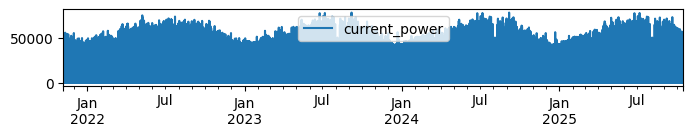

In [426]:
mpl.rcParams['figure.figsize'] = (8, 1)

plot_cols = ['current_power']
plot_features = df_filled[plot_cols]
plot_features.index = df_filled.index
_ = plot_features.plot(subplots=True)

# End fix missing row

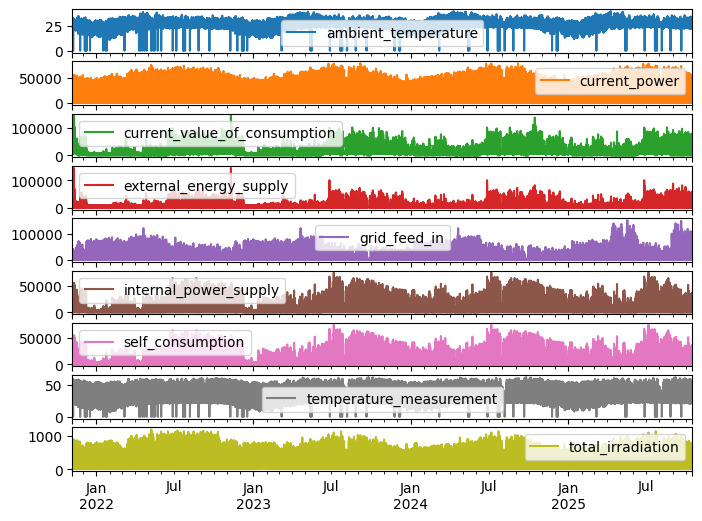

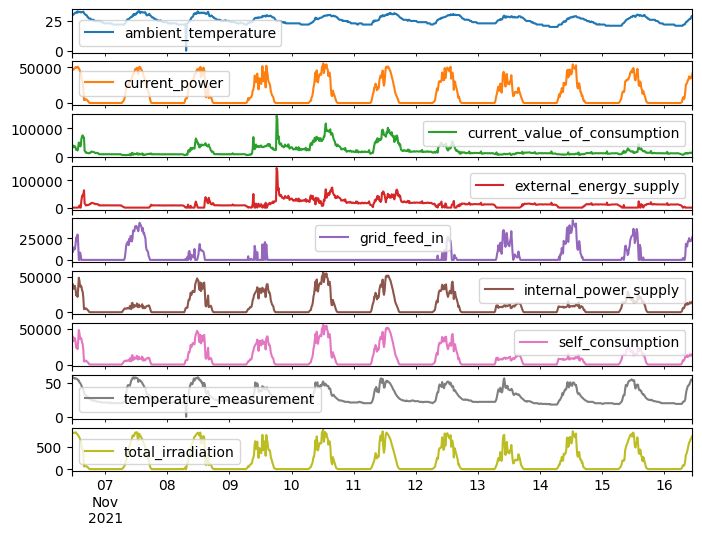

In [429]:
mpl.rcParams['figure.figsize'] = (8, 6)

plot_features = df_filled[all_cols]
plot_features.index = df_filled.index
_ = plot_features.plot(subplots=True)

plot_features = df_filled[all_cols][:960]
plot_features.index = df_filled.index[:960]
_ = plot_features.plot(subplots=True)

In [430]:
# Rename the index
df = df_filled.rename_axis('datetime')
df

,ambient_temperature,current_power,current_value_of_consumption,external_energy_supply,grid_feed_in,internal_power_supply,self_consumption,temperature_measurement,total_irradiation
datetime,,,,,,,,,
2021-11-06 11:15:00,30.288889,46519.355556,37280.422222,0.000000,9238.933333,37280.422222,37280.422222,58.022222,798.444444
2021-11-06 11:30:00,30.076923,47600.714286,39472.626374,0.000000,9397.756098,39132.406593,39132.406593,58.263736,812.571429
2021-11-06 11:45:00,30.629213,47056.988764,32669.393258,0.000000,14387.595506,32669.393258,32669.393258,57.235955,807.224719
2021-11-06 12:00:00,31.021978,48415.835165,36126.516484,0.000000,12289.318681,36126.516484,36126.516484,56.846154,817.527473
2021-11-06 12:15:00,31.831461,49345.404494,36879.966292,0.000000,12465.438202,36879.966292,36879.966292,55.842697,816.651685
...,...,...,...,...,...,...,...,...,...
2025-10-16 09:30:00,27.153846,27672.956044,60230.934066,32557.978022,0.000000,27672.956044,27672.956044,41.329670,305.120879
2025-10-16 09:45:00,27.865169,37596.426966,49211.348315,12787.851852,0.000000,37572.966292,37572.966292,51.561798,579.415730
2025-10-16 10:00:00,28.000000,33659.494505,36607.802198,12667.764706,0.000000,29508.285714,29508.285714,51.208791,452.934066


In [431]:
len(df)

138238

In [436]:
filename = Path(csv_file).name
base = re.split(r'\.', filename, 1)[0]
print(base)

device-1


In [441]:
# Compressed CSV
df_filled.to_csv(base + '_filled.csv')